In [22]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

sns.set(style="whitegrid")

In [23]:
# Load latest backtest file
EVAL_DIR = Path("../evaluation/")  # adjust as needed
csv_files = sorted(EVAL_DIR.glob("batch_backtest_*.csv"), reverse=True)

if not csv_files:
    raise FileNotFoundError("No backtest results found in the evaluation directory.")

df = pd.read_csv(csv_files[0])
print(f"[INFO] Loaded: {csv_files[0].name}")
df.head()

[INFO] Loaded: batch_backtest_20250712_192926.csv


,ticker,as_of_date,recommendation,reason,explanation,price_change_%
0,AAPL,2025-01-01,SELL,Weighted signals support a SELL with a confide...,**Summary:** I recommend SELLING AAPL at curre...,-3.22
1,AAPL,2025-02-01,HOLD,Signals are mixed; suggesting HOLD with a conf...,**Summary:** Hold onto AAPL for now.\n\n**Reas...,4.39
2,AAPL,2025-03-01,HOLD,Signals are mixed; suggesting HOLD with a conf...,**Summary:** Hold onto your AAPL shares for no...,-6.68
3,AAPL,2025-04-01,HOLD,Signals are mixed; suggesting HOLD with a conf...,**Summary:** HOLD on AAPL for now.\n\n**Reason...,-4.72
4,AAPL,2025-05-01,HOLD,Signals are mixed; suggesting HOLD with a conf...,**Summary:** HOLD AAPL for now.\n\n**Reason:**...,-2.19


Unique tickers: 12
Date range: 2025-01-01 to 2025-06-01


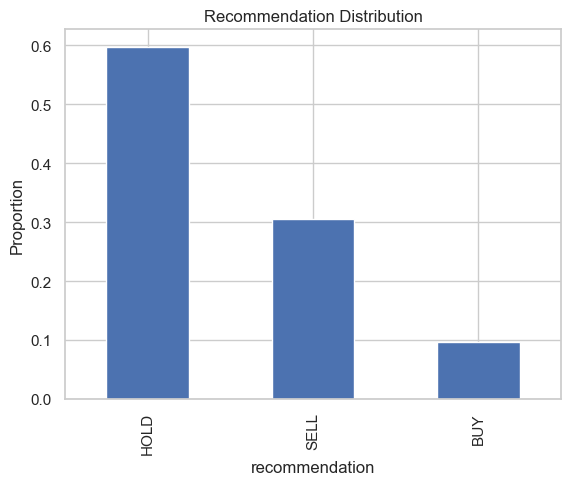

In [24]:
# Basic statistics
print("Unique tickers:", df['ticker'].nunique())
print("Date range:", df['as_of_date'].min(), "to", df['as_of_date'].max())
df['recommendation'].value_counts(normalize=True).plot(kind='bar', title='Recommendation Distribution', ylabel="Proportion")

plt.savefig('recommendation_distribution.png')
plt.show()



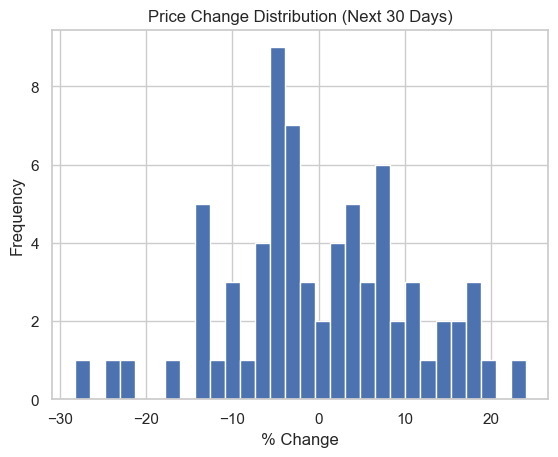

In [25]:
df['price_change_%'].hist(bins=30)
plt.title("Price Change Distribution (Next 30 Days)")
plt.xlabel("% Change")
plt.ylabel("Frequency")

plt.savefig('price_change_distribution.png')
plt.show()

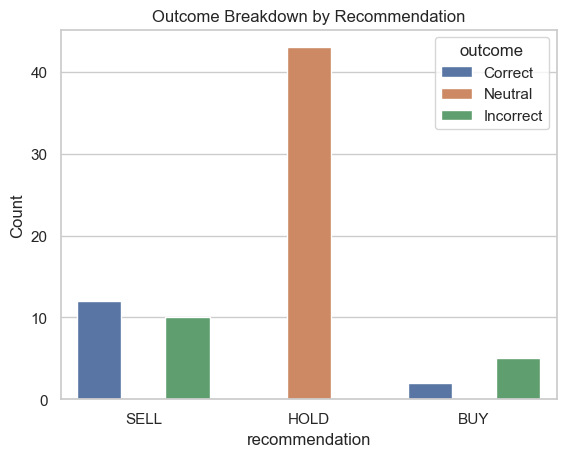

In [26]:
# Accuracy by recommendation
# Define success conditions: e.g., BUY when price rises, SELL when it drops
def classify_outcome(row):
    if pd.isna(row['price_change_%']):
        return "Unknown"
    if row['recommendation'] == "BUY" and row['price_change_%'] > 0:
        return "Correct"
    elif row['recommendation'] == "SELL" and row['price_change_%'] < 0:
        return "Correct"
    elif row['recommendation'] == "HOLD":
        return "Neutral"
    else:
        return "Incorrect"

df['outcome'] = df.apply(classify_outcome, axis=1)

# Plot
sns.countplot(data=df, x='recommendation', hue='outcome')
plt.title("Outcome Breakdown by Recommendation")
plt.ylabel("Count")
plt.savefig('outcome_breakdown_by_recommendation.png')
plt.show()

,count,mean,std
recommendation,,,
BUY,7,0.568571,12.760895
HOLD,43,2.030233,9.692692
SELL,22,-3.443182,11.539412


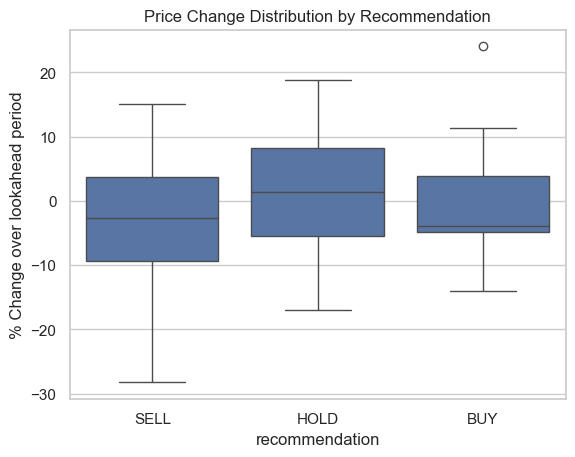

In [27]:
# Grouped summary
summary = df.groupby("recommendation")["price_change_%"].agg(["count", "mean", "std"])
display(summary)

# Visualise with boxplots
sns.boxplot(data=df, x="recommendation", y="price_change_%")
plt.title("Price Change Distribution by Recommendation")
plt.ylabel("% Change over lookahead period")

plt.savefig('price_change_distribution_by_recommendation.png')
plt.show()


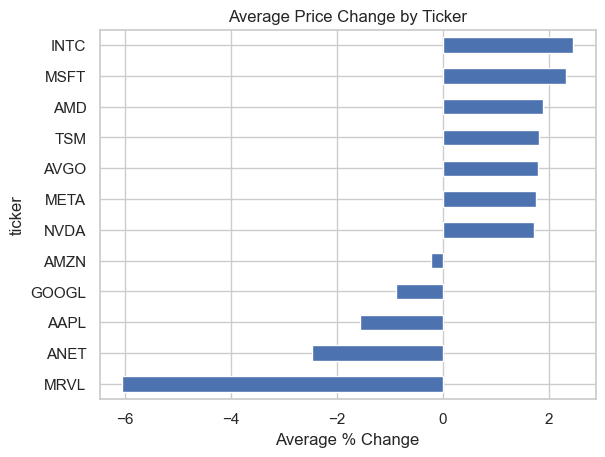

In [28]:
# Ticker-level insights
ticker_perf = df.groupby("ticker")["price_change_%"].mean().sort_values()
ticker_perf.plot(kind='barh', title='Average Price Change by Ticker')
plt.xlabel("Average % Change")
plt.savefig('price_change_by_ticker.png')
plt.show()


/tmp/ipykernel_27340/284901495.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="recommendation", y="price_change_%", palette="Set2")


,count,mean,std
recommendation,,,
BUY,7,0.568571,12.760895
HOLD,43,2.030233,9.692692
SELL,22,-3.443182,11.539412


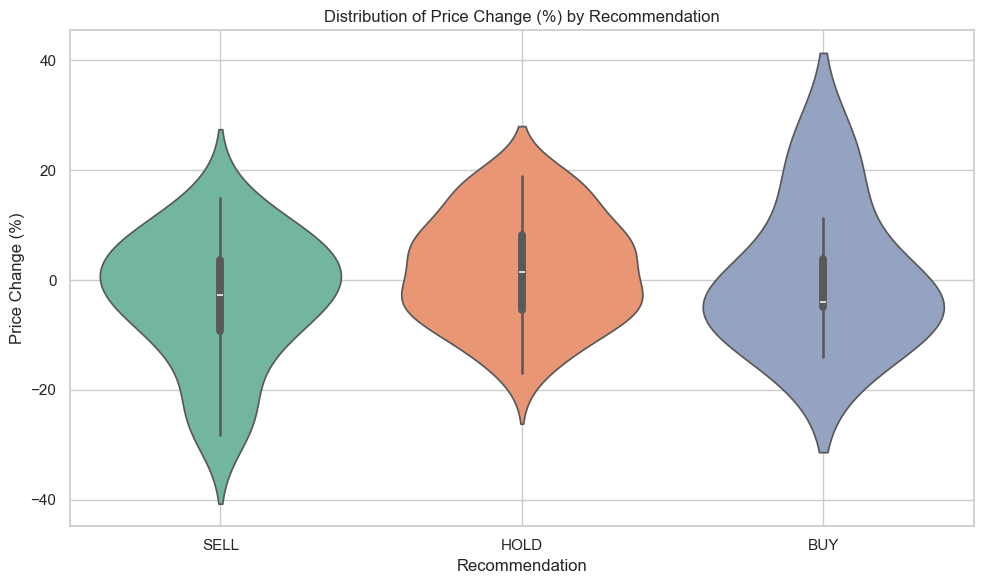

In [29]:
# Generate a violin plot for price change distribution by recommendation
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x="recommendation", y="price_change_%", palette="Set2")
plt.title("Distribution of Price Change (%) by Recommendation")
plt.ylabel("Price Change (%)")
plt.xlabel("Recommendation")
plt.grid(True)
plt.tight_layout()

display(summary)
plt.savefig('violin_plot.png')
plt.show()

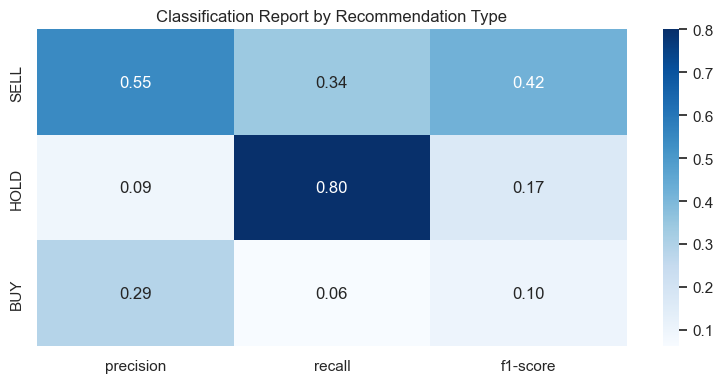

In [30]:
# Performance metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Map recommendation text to numeric labels
label_map = {"SELL": 0, "HOLD": 1, "BUY": 2}
df["predicted_label"] = df["recommendation"].map(label_map)

# Create actual labels from price change
threshold = 2  # percent
df["actual_label"] = df["price_change_%"].apply(
    lambda x: 2 if x > threshold else (0 if x < -threshold else 1)
)

# Drop any rows with missing predictions or outcomes
df_eval = df.dropna(subset=["predicted_label", "actual_label"])

# Compute classification metrics
report = classification_report(
    df_eval["actual_label"],
    df_eval["predicted_label"],
    target_names=["SELL", "HOLD", "BUY"],
    output_dict=True
)

# Display as DataFrame
metrics_df = pd.DataFrame(report).transpose()
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap of metrics
plt.figure(figsize=(8, 4))
sns.heatmap(metrics_df.loc[["SELL", "HOLD", "BUY"], ["precision", "recall", "f1-score"]],
            annot=True, fmt=".2f", cmap="Blues")
plt.title("Classification Report by Recommendation Type")
plt.tight_layout()
plt.savefig('classification_report_by_recommendation.png')
plt.show()



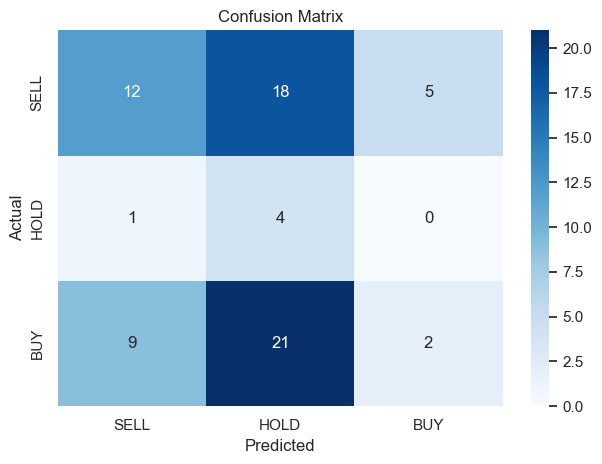

In [32]:
cm = confusion_matrix(df_eval["actual_label"], df_eval["predicted_label"])

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["SELL", "HOLD", "BUY"],
            yticklabels=["SELL", "HOLD", "BUY"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()


# SHAP

In [43]:
import sys
import os

# Add the project root to the Python path
project_root = os.path.abspath("../")  # Adjust path if needed
if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [44]:
import shap
import numpy as np
import pandas as pd
import joblib

# Load model and scaler
from tensorflow.keras.models import load_model
import h5py

model = load_model("../models/tf_model.h5", compile=False)


scaler = joblib.load("../models/scaler.pkl")

# Load or recompute feature data
from app.strategy_engine.ml_classifier import compute_features, fetch_ticker_data

df = fetch_ticker_data("AAPL")
features_df = compute_features(df)

# Select only the most recent 100 samples to keep SHAP manageable
X = features_df[['SMA_10', 'SMA_50', 'SMA_diff', 'RSI', 'MACD',
                 'Return_1d', 'Return_5d', 'Return_10d', 'Volume']].tail(100)

# Scale
X_scaled = scaler.transform(X)


[INFO] Loading cached data for AAPL from /home/andreas/Software/genaiadvisor/code/data/AAPL_10y.csv


In [46]:
import shap

# Convert scaled numpy array to a DataFrame with column names
X_df = pd.DataFrame(X_scaled, columns=[
    'SMA_10', 'SMA_50', 'SMA_diff', 'RSI', 'MACD',
    'Return_1d', 'Return_5d', 'Return_10d', 'Volume'
])

# Use a small background sample for SHAP
background = X_df.sample(n=20, random_state=42)

# Create SHAP DeepExplainer (recommended for TF/Keras models)
explainer = shap.KernelExplainer(model.predict, background)

# Calculate SHAP values for all 100 samples
shap_values = explainer.shap_values(X_df, nsamples=100)


2025-07-12 20:34:36.803813: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2025-07-12 20:34:36.804057: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz
2025-07-12 20:34:36.996193: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
100%|██████████| 100/100 [00:05<00:00, 17.79it/s]


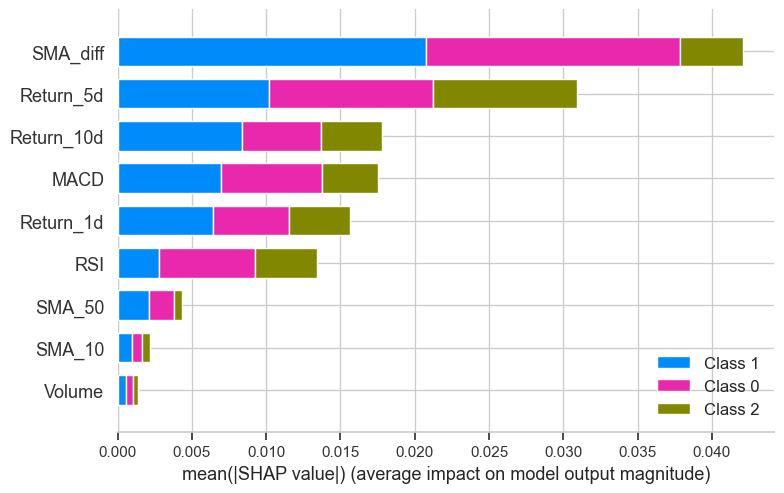

In [56]:
import matplotlib.pyplot as plt
import shap

# Create the SHAP summary bar plot
shap.summary_plot(shap_values, X_df, plot_type="bar", show=False)

# Save the figure
plt.savefig("shap_summary_bar.png", bbox_inches="tight", dpi=300)

# Show the plot
plt.show()

